In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment analysis /text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
df.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [ ]:
df = df[['text', 'label']]
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = df.sample(frac=0.1)

In [ ]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TFBertForSequenceClassification

In [ ]:
# tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
text = df['text'].values
max_length = 128
Xids = np.zeros((len(text), max_length))
Xmask = np.zeros((len(text), max_length))

for i, sentence in enumerate(text):
    tokens = tokenizer.encode_plus(sentence, max_length=max_length, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
y = df['label']
y = to_categorical(y)

# Split the data into training, testing and validation sets
Xids_train, Xids_test, y_train, y_test = train_test_split(Xids, y, test_size=0.2, random_state=42)
Xids_train, Xids_val, y_train, y_val = train_test_split(Xids_train, y_train, test_size=0.2, random_state=42)

In [ ]:
def build_custom_learning_rate(initial_lr, decay_steps, decay_rate):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    return lr_schedule

In [ ]:
import tensorflow as tf

In [ ]:
# Define attention embedder
class AttentionEmbedder(tf.keras.Model):
    def __init__(self, units):
        super(AttentionEmbedder, self).__init__()
        self.Wq = tf.keras.layers.Dense(units)
        self.Wk = tf.keras.layers.Dense(units)
        self.Wv = tf.keras.layers.Dense(units)
        self.units = units

    def call(self, inputs):
        q = self.Wq(inputs)
        k = self.Wk(inputs)
        v = self.Wv(inputs)
        return q, k, v

In [ ]:
# Define attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, GRU, concatenate, GlobalMaxPooling1D, Embedding, MultiHeadAttention
from tensorflow.keras.utils import to_categorical

In [ ]:
vocab_size = tokenizer.vocab_size + 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, Dense, concatenate, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GRU, GlobalMaxPooling1D, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
def bullying_model_with_attention(max_length, embedding_dim, attention_units, vocab_size):

    input_ids = Input(shape=(max_length,), dtype='int32', name="input_ids")
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=max_length)(input_ids)

    # Apply attention
    attention_embedder = AttentionEmbedder(attention_units)
    q, k, v = attention_embedder(embedding_layer)
    attention_layer = Attention()
    attention_output, attention_weights = attention_layer(q, k, v, mask=None)

    attended_sequences = concatenate([embedding_layer, attention_output], axis=-1)

    # Model architecture
    lstm_layer = LSTM(64, activation='relu', return_sequences=True)(attended_sequences)
    cnn_layer = Conv1D(64, 3, activation='relu')(attended_sequences)

    lstm_layer2 = LSTM(64, activation='relu', return_sequences=True)(lstm_layer)
    cnn_layer2 = Conv1D(64, 3, activation='relu')(cnn_layer)

    # GlobalMaxPooling1D layer for each
    lstm_pooled = GlobalMaxPooling1D()(lstm_layer2)
    cnn_pooled = GlobalMaxPooling1D()(cnn_layer2)

    # Concatenate the pooled layers
    concatenated = concatenate([lstm_pooled, cnn_pooled])

    dense_layer = Dense(128, activation='relu')(concatenated)
    dense_layer = Dense(64, activation='relu')(dense_layer)

    # Define the output layer
    output_layer = Dense(6, activation='softmax')(dense_layer)

    hybrid_model = Model(inputs=input_ids, outputs=output_layer)
    return hybrid_model

# Replace `vocab_size` with the actual vocabulary size
model = bullying_model_with_attention(max_length=128, embedding_dim=768, attention_units=64, vocab_size=vocab_size)

In [ ]:
# For example:
Xids_train = Xids_train.reshape(-1, max_length)
Xids_val = Xids_val.reshape(-1, max_length)
Xids_test = Xids_test.reshape(-1, max_length)

In [ ]:
# Build and compile the model
embedding_dim = 768
attention_units = 64
initial_lr = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = build_custom_learning_rate(initial_lr, decay_steps, decay_rate)
model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 10
batch_size = 32
history = model.fit(
    {'input_ids': Xids_train},
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=({'input_ids': Xids_val}, y_val),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
834/834 [==============================] - 329s 379ms/step - loss: 1.8784 - accuracy: 0.8052 - val_loss: 0.1997 - val_accuracy: 0.9168
Epoch 2/10
834/834 [==============================] - 307s 368ms/step - loss: 0.1363 - accuracy: 0.9421 - val_loss: 0.2104 - val_accuracy: 0.9126
Epoch 3/10
834/834 [==============================] - 314s 377ms/step - loss: 0.0837 - accuracy: 0.9648 - val_loss: 0.2447 - val_accuracy: 0.9054
Epoch 4/10
834/834 [==============================] - 314s 376ms/step - loss: 4289417.0000 - accuracy: 0.9655 - val_loss: 0.2632 - val_accuracy: 0.9058


In [ ]:
import matplotlib.pyplot as plt

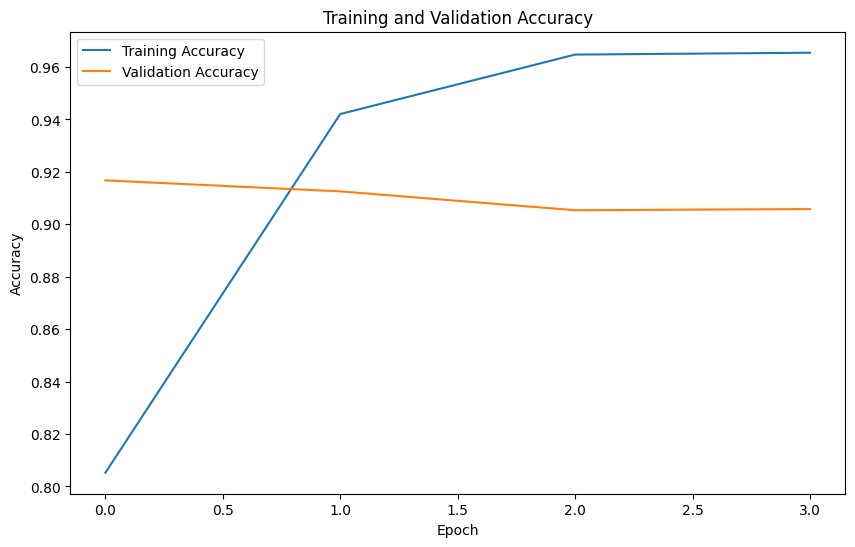

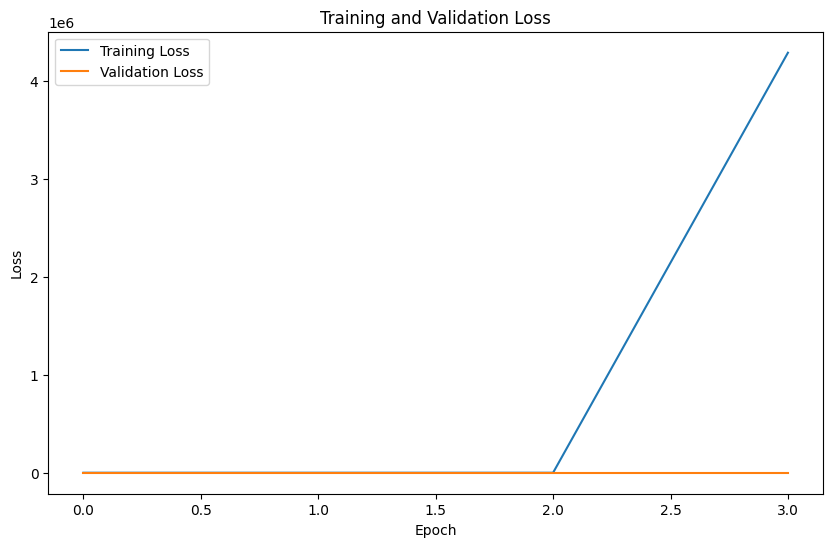

In [ ]:
# plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate({'input_ids': Xids_test}, y_test, batch_size=batch_size)
print("Test accuracy:", test_accuracy)

# Make predictions on the test set
y_pred = model.predict({'input_ids': Xids_test})
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

261/261 [==============================] - 13s 48ms/step - loss: 0.1847 - accuracy: 0.9226
Test accuracy: 0.9226340651512146
261/261 [==============================] - 21s 78ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import seaborn as sns

              precision    recall  f1-score   support

     sadness       0.95      0.96      0.96      2438
         joy       0.94      0.96      0.95      2862
        love       0.89      0.79      0.84       676
       anger       0.92      0.92      0.92      1142
        fear       0.92      0.85      0.88       953
    surprise       0.69      0.86      0.77       266

    accuracy                           0.92      8337
   macro avg       0.88      0.89      0.88      8337
weighted avg       0.92      0.92      0.92      8337



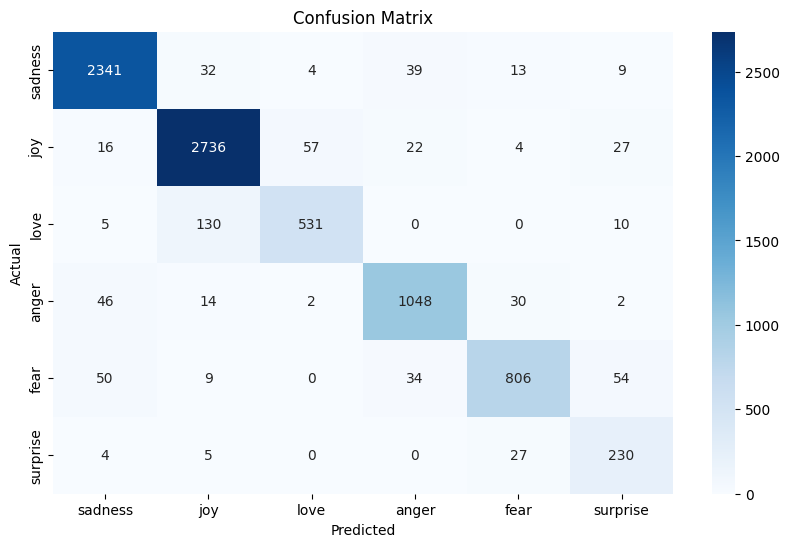

In [ ]:
emotion_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# generate classfication report 0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'
print(classification_report(y_test, y_pred, target_names=emotion_mapping.values()))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9239366666640264
Recall: 0.9226340410219503
F1 Score: 0.9224927446178868


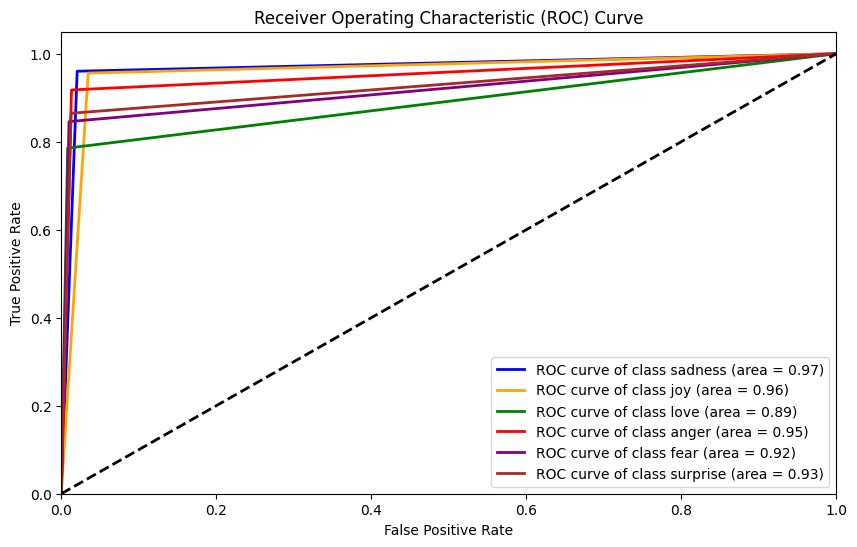

In [ ]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 6
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(emotion_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

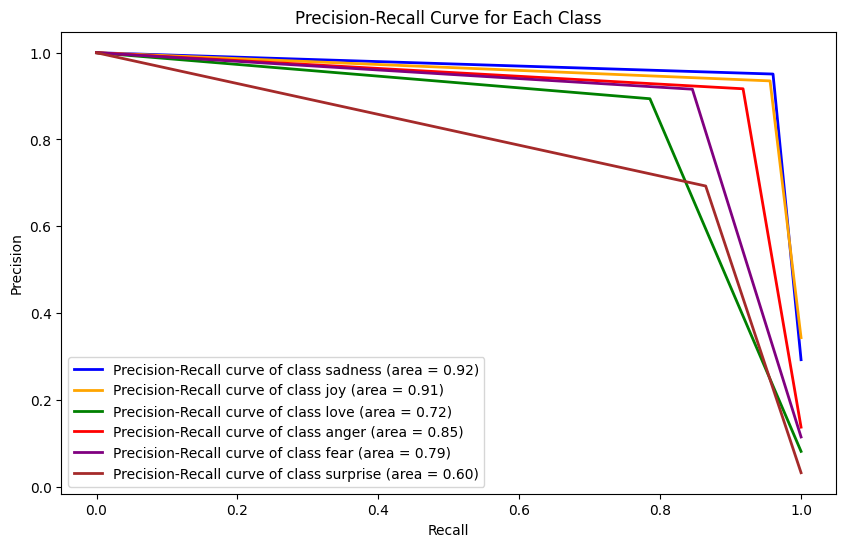

In [ ]:
# plot precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()  # average precision score
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(emotion_mapping[i], average_precision[i]))

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.show()



In [ ]:
import tensorflow as tf

In [ ]:
# create a model custom attention embedder
def create_model(max_length):
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
    input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')
    outputs = model.bert(input_ids, attention_mask=attention_mask)
    net = outputs.pooler_output
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(6, activation='softmax')(net)
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=net)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = create_model(max_length)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [ ]:
history = model.fit(
    [Xids_train, Xids_train],
    y_train,
    validation_data=([Xids_val, Xids_val], y_val),
    epochs=1,
    batch_size=32
  )

8337/8337 [==============================] - 7118s 854ms/step - loss: 0.9352 - accuracy: 0.6513 - val_loss: 0.9281 - val_accuracy: 0.6555


In [ ]:
# Extract features from the model
features = model.predict([Xids, Xmask])

 6319/13026 [=============>................] - ETA: 31:18

In [ ]:
# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Hybrid Attention Embedder**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# create attention embedder with q, k, v
class AttentionEmbedder(tf.keras.Model):
    def __init__(self, units):
        super(AttentionEmbedder, self).__init__()
        self.Wq = tf.keras.layers.Dense(units)
        self.Wk = tf.keras.layers.Dense(units)
        self.Wv = tf.keras.layers.Dense(units)
        self.units = units

    def call(self, inputs):
        q = self.Wq(inputs)
        k = self.Wk(inputs)
        v = self.Wv(inputs)
        return q, k, v

In [ ]:
# create attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

In [ ]:
def create_model():
    inputs = tf.keras.Input(shape=(768,))
    q, k, v = AttentionEmbedder(64)(inputs)
    attention, weights = Attention()(q, k, v, mask=None)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(attention)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

ValueError: Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=1
)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)